In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, classification_report, cohen_kappa_score
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from skimage.segmentation import slic, mark_boundaries, felzenszwalb, quickshift, random_walker
from scipy.sparse import coo_matrix
from torchinfo import summary
from operator import index, truediv
import matplotlib.pyplot as plt
import spectral

# CUDA or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
####################################################################

class CNN_Denoise_layer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super(CNN_Denoise_layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.BN = nn.BatchNorm2d(in_dim)
        self.OO_conv = nn.Conv2d(in_dim, out_dim, kernel_size=(1, 1))
        self.Activition = nn.LeakyReLU()
    def forward(self, X):
        X = self.BN(X)
        X = self.OO_conv(X)
        X = self.Activition(X)
        return X

class SSConv(nn.Module):
    '''
    Spectral-Spatial Convolution
    '''
    def __init__(self, in_ch, out_ch,kernel_size=3):
        super(SSConv, self).__init__()
        self.point_conv = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1,
            stride=1,
            padding=0,
            groups=1,
            bias=False
        )
        self.depth_conv = nn.Conv2d(
            in_channels=out_ch,
            out_channels=out_ch,
            kernel_size=kernel_size,
            stride=1,
            padding=kernel_size//2,
            groups=out_ch
        )
        
        self.Act1 = nn.LeakyReLU()
        self.Act2 = nn.LeakyReLU()
        self.BN=nn.BatchNorm2d(in_ch)
        
    
    def forward(self, input):
        out = self.point_conv(self.BN(input))
        out = self.Act1(out)
        out = self.depth_conv(out)
        out = self.Act2(out)
        return out


# adaptive improved GCN
class AIGCN_layer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, 
                 A: torch.Tensor, AIGCN_K: int):
        # in_dim: dim of input feature in current layer
        # out_dim: dim of output feature in current layer
        super(AIGCN_layer, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.AIGCN_K = AIGCN_K
        self.A = A
        n_nodes = self.A.shape[0]
        self.I = torch.eye(n_nodes, n_nodes, requires_grad=False).to(device)

        self.BN = nn.BatchNorm1d(in_dim)
        self.GCN_liner = nn.Linear(in_dim, out_dim)
        self.Activition = nn.LeakyReLU()
        
        self.h_coeffs = torch.nn.Parameter(torch.tensor([0.01],requires_grad=True))


    def A_to_D_inv(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/torch.sqrt(d)
        D_inv = torch.diag(d)
        return D_inv        
    def get_normal_Adjacency(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/torch.sqrt(d)
        D_inv = torch.diag(d)
        A = torch.matmul(D_inv, torch.matmul(A,D_inv))
        return A
    def get_randwalk_Adjacency(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/d
        D_inv = torch.diag(d)
        A = torch.matmul(D_inv, A)
        return A    
        
    def forward(self, X):
        X = self.BN(X)

     ## method-1 good normal A ===========================
        A = self.I + torch.abs(self.h_coeffs)*self.A
        A = self.get_normal_Adjacency(A)
        A = torch.matrix_power(A, self.AIGCN_K)
        X = torch.mm(A, self.GCN_liner(X))

        X = self.Activition(X)          

        return X
        

# adaptive improved GCN with multiple affinity matrics
class AIGCN_MA_layer(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, 
            A1: torch.Tensor, A2: torch, AIGCN_K: int):
        super(AIGCN_MA_layer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.AIGCN_K = AIGCN_K
        self.A1 = A1
        self.A2 = A2
        n_nodes = self.A1.shape[0]
        self.I = torch.eye(n_nodes, n_nodes, requires_grad=False).to(device)

        self.BN = nn.BatchNorm1d(in_dim)
        self.GCN_liner = nn.Linear(in_dim, out_dim)
        self.Activition = nn.LeakyReLU()

        self.alpha = torch.nn.Parameter(torch.tensor([0.5],requires_grad=True))        
        self.h_coeffs = torch.nn.Parameter(torch.tensor([0.01],requires_grad=True))    
        
           
            
    def A_to_D_inv(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/torch.sqrt(d)
        D_inv = torch.diag(d)
        return D_inv
    def get_randwalk_Adjacency(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/d
        D_inv = torch.diag(d)
        A = torch.matmul(D_inv, A)
        return A        
    def get_normal_Adjacency(self, A: torch.Tensor):
        d = A.sum(1)
        d = 1/torch.sqrt(d)
        D_inv = torch.diag(d)
        A = torch.matmul(D_inv, torch.matmul(A,D_inv))
        return A    
    def forward(self, X):
        X = self.BN(X)

        # # method-1 
        A0 = (1-torch.abs(self.alpha))*self.A1 + torch.abs(self.alpha)*self.A2
        A = self.I + torch.abs(self.h_coeffs)*A0
        A = self.get_normal_Adjacency(A)
        A = torch.matrix_power(A, self.AIGCN_K)
        X = torch.mm(A, self.GCN_liner(X))
        X = self.Activition(X)              
        
        # # method-2 random walk
        # A0 = (1-torch.abs(self.alpha))*self.A1 + torch.abs(self.alpha)*self.A2
        # A = self.I + torch.abs(self.h_coeffs)*A0
        # A = self.get_randwalk_Adjacency(A)
        # A = torch.matrix_power(A, self.AIGCN_K)
        # X = torch.mm(A, self.GCN_liner(X))
        # X = self.Activition(X)               
                         
             
        
        return X        
    
class AIGCN_NET(nn.Module):
    def __init__(self, height: int, width: int, in_dim: int, class_num: int,
                 H: torch.Tensor, Pos0:torch, 
                 As: torch.Tensor, Af:torch.Tensor, 
                 AIGCN_K_As: int,AIGCN_K_Af: int,AIGCN_K_Ac: int):
        super(AIGCN_NET, self).__init__()
        self.height = height
        self.width = width
        self.in_dim = in_dim
        self.class_num = class_num
        self.H = H
        self.Pos0 = Pos0
        self.As = As
        self.Af = Af
        self.n_nodes = As.shape[0]
        self.AIGCN_K_As = AIGCN_K_As
        self.AIGCN_K_Af = AIGCN_K_Af
        self.AIGCN_K_Ac = AIGCN_K_Ac

        out_dim     = 128
        final_dim   = 128
        # (1) CNN denoise layer
        self.CNN_denoise_branch = nn.Sequential()
        self.CNN_denoise_branch.add_module('CNNDenoise1',
                CNN_Denoise_layer(in_dim, out_dim))
        self.CNN_denoise_branch.add_module('CNNDenoise2',
                CNN_Denoise_layer(out_dim, out_dim))
        
        ## good
        # (2) As
        self.As_layer1 = AIGCN_layer(out_dim, out_dim, As, AIGCN_K_As)
        self.As_layer2 = AIGCN_layer(out_dim, final_dim, As, AIGCN_K_As)
        
        # (3) Af
        self.Af_layer1 = AIGCN_layer(out_dim, out_dim, Af, AIGCN_K_Af)
        self.Af_layer2 = AIGCN_layer(out_dim, final_dim, Af, AIGCN_K_Af)
        
        
        # (4) As+Af
        self.Ac_layer1 = AIGCN_MA_layer(out_dim, out_dim, As, Af, AIGCN_K_Ac)
        self.Ac_layer2 = AIGCN_MA_layer(out_dim, final_dim, As, Af, AIGCN_K_Ac)
     
        
        # (5) CNN: SSConv 
        self.CNN_Branch = nn.Sequential()
        self.CNN_Branch.add_module('CNN_Branch1',
                                SSConv(out_dim, out_dim,kernel_size=5))
        self.CNN_Branch.add_module('CNN_Branch2',
                                SSConv(out_dim, final_dim,kernel_size=5))
        
        # (6)
        self.Softmax_linear =nn.Sequential(nn.Linear(final_dim*3, class_num))

    def pixel_2_superpixel(self, X: torch.Tensor):
        dv = self.H.sum(0)
        Dv_inv = torch.diag(1/dv)
        HD = torch.mm(self.H, Dv_inv)
        # X_flatten = X.reshape([self.height*self.width],-1)

        X_flatten = X.reshape(-1, X.shape[2])
        S = torch.mm(HD.t(), X_flatten)
        
        return S
    def superpixel_2_pixel(self, S: torch.Tensor):
        # dv = self.H.sum(0)
        # Dv = torch.diag(1/dv)
        # HD = torch.mm(self.H, Dv)

        X = torch.matmul(self.H, S)        
        # X = torch.matmul(HD, S)        
        
        return X

    def forward(self, X:torch.Tensor):
        X = self.CNN_denoise_branch(torch.unsqueeze(X.permute([2, 0, 1]), 0))
        X = torch.squeeze(X, 0).permute([1, 2, 0])
        X_clean = X
              
        # (batch_size, channel, high, weight)
        X_clean = torch.unsqueeze(X_clean.permute([2, 0, 1]), 0)
        Z_CNN = self.CNN_Branch(X_clean)
        Z_CNN = torch.squeeze(Z_CNN, 0).permute([1, 2, 0]).reshape([self.height * self.width, -1])             
        
        # obtain superpixels S and background pixels X0
        S = self.pixel_2_superpixel(X)

        # As_GCNs 
        ZS = self.As_layer1(S)
        ZS = self.As_layer2(ZS)
        
        # Af_GCNs 
        ZF = self.Af_layer1(S)
        ZF = self.Af_layer2(ZF)
        
        # Ac_GCNs 
        # ZC = self.Ac_layer1(S)
        # ZC = self.Ac_layer2(ZC)
        
        
        # X_ZS = torch.matmul(self.H, ZS)
        # X_ZF = torch.matmul(self.H, ZF)     
        # X_ZC = torch.matmul(self.H, ZC)     
        
        X_ZS = self.superpixel_2_pixel(ZS)
        X_ZF = self.superpixel_2_pixel(ZF)
        # X_ZC = self.superpixel_2_pixel(ZC)
        
        # X_GCN = torch.concat((X_ZS, X_ZF, X_ZC), dim=1)
        X_GCN = torch.concat((X_ZS, X_ZF), dim=1)
        X_Z = torch.concat((X_GCN, Z_CNN), dim=1)
        # X_Z = Z_CNN
        Z = self.Softmax_linear(X_Z)
  
       

        return Z

def compute_loss(predict: torch.Tensor, reallabel_onehot: torch.Tensor, reallabel_mask: torch.Tensor):
    real_labels = reallabel_onehot
    we = -torch.mul(real_labels,torch.log(predict))
    we = torch.mul(we, reallabel_mask)
    pool_cross_entropy = torch.sum(we)
    return pool_cross_entropy
    


def get_TrainValTest_Sets(seed: int, gt: np.array, class_count: int, train_ratio, 
                   val_ratio, samples_type: str = 'ratio', ):
    # step2:随机10%数据作为训练样本。方式：给出训练数据与测试数据的GT
    random.seed(seed)
    [height, width] = gt.shape
    gt_reshape = np.reshape(gt, [-1])
    train_rand_idx = []
    val_rand_idx = []
    if samples_type == 'ratio':
        train_number_per_class = []
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            
            rand_idx = random.sample(rand_list,
                                     np.ceil(samplesCount * train_ratio).astype('int32') + \
                                     np.ceil(samplesCount * val_ratio).astype('int32'))  # 随机数数量 四舍五入(改为上取整)
            train_number_per_class.append(np.ceil(samplesCount * train_ratio).astype('int32'))
            rand_real_idx_per_class = idx[rand_idx]
            train_rand_idx.append(rand_real_idx_per_class)
        train_rand_idx = np.array(train_rand_idx, dtype=object)
        train_data_index = []
        val_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = list(train_rand_idx[c])
            train_data_index = train_data_index + a[:train_number_per_class[c]]
            val_data_index = val_data_index + a[train_number_per_class[c]:]
            # for j in range(a.shape[0]):
            #     train_data_index.append(a[j][0:train_number_per_class])
            #     val_data_index.append()
        # train_data_index = np.array(train_data_index).reshape([-1])
        # val_data_index = np.array(val_data_index).reshape([-1])
        
        ##将测试集（所有样本，包括训练样本）也转化为特定形式
        train_data_index = set(train_data_index)
        val_data_index = set(val_data_index)
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)
        
        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index - val_data_index - background_idx
        
        # # 从测试集中随机选取部分样本作为验证集
        # val_data_count = np.ceil(val_ratio * (len(test_data_index) + len(train_data_index))).astype('int32')  # 验证集数量
        # val_data_index = random.sample(test_data_index, val_data_count)
        # val_data_index = set(val_data_index)
        
        # test_data_index = test_data_index - val_data_index  # 由于验证集为从测试集分裂出，所以测试集应减去验证集
        
        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)
    
    if samples_type == 'same_num':
        if int(train_ratio) == 0 or int(val_ratio) == 0:
            print("ERROR: The number of samples for train. or val. is equal to 0.")
            exit(-1)
        for i in range(class_count):
            idx = np.where(gt_reshape == i + 1)[-1]
            samplesCount = len(idx)
            real_train_samples_per_class = int(train_ratio)  # 每类相同数量样本,则训练比例为每类样本数量
            real_val_samples_per_class = int(val_ratio)  # 每类相同数量样本,则训练比例为每类样本数量
            
            rand_list = [i for i in range(samplesCount)]  # 用于随机的列表
            if real_train_samples_per_class >= samplesCount:
                real_train_samples_per_class = samplesCount - 1
                real_val_samples_per_class = 1
            else:
                real_val_samples_per_class = real_val_samples_per_class if (
                                                                                       real_val_samples_per_class + real_train_samples_per_class) <= samplesCount else samplesCount - real_train_samples_per_class
            rand_idx = random.sample(rand_list,
                                     real_train_samples_per_class + real_val_samples_per_class)  # 随机数数量 四舍五入(改为上取整)
            rand_real_idx_per_class_train = idx[rand_idx[0:real_train_samples_per_class]]
            train_rand_idx.append(rand_real_idx_per_class_train)
            if real_val_samples_per_class > 0:
                rand_real_idx_per_class_val = idx[rand_idx[-real_val_samples_per_class:]]
                val_rand_idx.append(rand_real_idx_per_class_val)
        
        train_rand_idx = np.array(train_rand_idx)
        val_rand_idx = np.array(val_rand_idx)
        train_data_index = []
        for c in range(train_rand_idx.shape[0]):
            a = train_rand_idx[c]
            for j in range(a.shape[0]):
                train_data_index.append(a[j])
        train_data_index = np.array(train_data_index)
        
        val_data_index = []
        for c in range(val_rand_idx.shape[0]):
            a = val_rand_idx[c]
            for j in range(a.shape[0]):
                val_data_index.append(a[j])
        val_data_index = np.array(val_data_index)
        
        train_data_index = set(train_data_index)
        val_data_index = set(val_data_index)
        
        all_data_index = [i for i in range(len(gt_reshape))]
        all_data_index = set(all_data_index)
        
        # 背景像元的标签
        background_idx = np.where(gt_reshape == 0)[-1]
        background_idx = set(background_idx)
        test_data_index = all_data_index - train_data_index - val_data_index - background_idx
        
        # # 从测试集中随机选取部分样本作为验证集
        # val_data_count = int(val_samples)  # 验证集数量
        # val_data_index = random.sample(test_data_index, val_data_count)
        # val_data_index = set(val_data_index)
        
        # test_data_index = test_data_index - val_data_index
        # 将训练集 验证集 测试集 整理
        test_data_index = list(test_data_index)
        train_data_index = list(train_data_index)
        val_data_index = list(val_data_index)
    
    # # 获取训练样本的标签图
    train_samples_gt = np.zeros(gt_reshape.shape)
    for i in range(len(train_data_index)):
        train_samples_gt[train_data_index[i]] = gt_reshape[train_data_index[i]]
        pass

    train_gt_map = train_samples_gt
    return train_data_index,test_data_index,val_data_index, train_gt_map

## function: SAM and SLIC
def get_SAM_Segs(Img, SAM_points_in_row_width, SAM_iou_thresh, SAM_score_thresh):
        # SAM Parameters
    points_in_row_width = SAM_points_in_row_width
    iou_thresh = SAM_iou_thresh
    score_thresh = SAM_score_thresh

    from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
    sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
    sam = sam.to(device)
    mask_generator = SamAutomaticMaskGenerator(
                    model=sam,
                    points_per_side = points_in_row_width,
                    # points_per_batch=64,
                    pred_iou_thresh = iou_thresh,
                    stability_score_thresh = score_thresh,
                    crop_n_layers=1,
                    crop_n_points_downscale_factor=2,
                        min_mask_region_area=10,  # Requires open-cv to run post-processing
                )

    masks = mask_generator.generate(Img)
    h,w = Img.shape[0],Img.shape[1]
    z = len(masks)
    
    # H_SAM = coo_matrix((h*w,z),dtype=np.int8).toarray() 
    H_SAM = coo_matrix((h*w, z+1),dtype=np.int8).toarray() 
    # w_score = coo_matrix((z,1),dtype=np.int8).toarray() 
    # w_iou = coo_matrix((z,1),dtype=np.int8).toarray() 

    # H_SAM = np.zeros((h*w, z))
    # w_score = np.zeros(z)
    # w_iou = np.zeros(z)
  
    # stability_score
    # predicted_iou

    id_col = 0
    for mask in masks:
        seg = mask['segmentation']
        seg = np.reshape(seg, -1)
        idx = np.where(seg == True)

        H_SAM[idx, id_col] =1
        # w_score[id_col] = mask['stability_score']
        # w_iou[id_col] = mask['predicted_iou']

        id_col = id_col +1
    
    pos_zeros = np.where(np.all(H_SAM == 0, axis = 1))
    pos_zeros = pos_zeros[0]
    H_SAM[pos_zeros, z] = 1
    
    return H_SAM

def get_SLIC_Segs(Img, SLIC_scale):
    # SLIC Parameters
    ###### SLIC  #########
    h,w = Img.shape[0],Img.shape[1]
    n_SLIC_segs = h*w/SLIC_scale
    SLIC_segs = slic(Img, n_SLIC_segs)
    # plt.imshow(SLIC_segs)
    # plt.show()
    SLIC_segs = np.reshape(SLIC_segs,(-1))
    id_Segs = np.unique(SLIC_segs)
    n_Segs = len(id_Segs)
    H_SLIC = coo_matrix((h*w,n_Segs),dtype=np.int8).toarray()
    for j in range(len(id_Segs)):
        idx = np.where(SLIC_segs == id_Segs[j])
        H_SLIC[idx, j] = 1

    # output matlab data
    # sio.savemat(mat_file_SLIC, {'H': H})
    
    return H_SLIC

##################
# Function: CreateAs
# Date: 2023-10-29
# Params:
    # H: asssociated matrix
    # S: featrue matrix
    # sigma:kernel width
    # vmargin: edge margin
def CreateAs(H,S,sigma, ed_margin):  
    # generate mask for edge set
    HTH = H.T @ H
    #  print(np.min(HTH))
    #  print(np.count_nonzero(HTH == 0))    
    M = np.zeros_like(HTH)
    P = np.where(HTH > ed_margin)
    M[P] = 1
    # plt.imshow(M)
    # plt.figure()

    # edge weights: Gaussian kernel, row of S is vertex
    R = np.linalg.norm(S, axis=1)**2
    R = R.reshape(-1,1)
    SST = S @ S.T
    e = np.ones((S.shape[0], 1))
    R = R @ e.T
    K = R+R.T-2*SST
    A = np.exp(-K/sigma)
    # plt.imshow(A)
    # plt.figure()

    A = np.multiply(A, M)
    # plt.imshow(A)
    # plt.figure()
    np.fill_diagonal(A, 0)  # remove diagnal 
    # plt.imshow(A)
    # plt.figure()

    return A

# Function: CreateAf
# Date: 2023-10-29
# Params:
    # H: asssociated matrix
    # S: featrue matrix
    # sigma:kernel width
    # max_K: K neigbors
def CreateAf(H,S,sigma, max_K):  
    # edge weights
    R = np.linalg.norm(S, axis=1)**2
    R = R.reshape(-1,1)
    SST = S @ S.T
    e = np.ones((S.shape[0], 1))
    R = R @ e.T
    K = R+R.T-2*SST
    A1 = np.exp(-K/sigma)
    np.fill_diagonal(A1, 0)
    A = np.zeros_like(A1) 
    for i in range(A1.shape[1]):
        sorted_index = np.argsort(A1[:, i])[::-1]
        A[sorted_index[:max_K],i] = A1[sorted_index[:max_K],i]
    return 0.5*(A+A.T)    
    
class CTrainValTest_Sets():
    train_data_index    = []
    test_data_index     = []
    val_data_index      = []
    train_gt_map        = []
    
    train_gt            = []
    val_gt              = []
    test_gt             = []

    def get_TrainValTest_Sets(self, cur_seed,
            gt,class_num,train_ratio,val_ratio, samples_type):
        (train_data_index,
         test_data_index, 
         val_data_index, 
         train_gt_map) = get_TrainValTest_Sets(cur_seed,
                gt,class_num, train_ratio,val_ratio, samples_type)
         
        gt_flatten = np.reshape(gt, -1)
        
        # label of training set
        train_gt = gt_flatten[train_data_index]
        train_gt = train_gt - 1
        train_gt = torch.from_numpy(train_gt).to(device)
        self.train_gt = train_gt.long()
    
        # label of valid set
        val_gt = gt_flatten[val_data_index]
        val_gt = val_gt - 1
        val_gt = torch.from_numpy(val_gt).to(device)
        self.val_gt = val_gt.long()
        
        # label of test set
        test_gt = gt_flatten[test_data_index]
        test_gt = test_gt - 1
        test_gt = torch.from_numpy(test_gt).to(device)
        self.test_gt = test_gt.long()
        
        self.train_data_index   = train_data_index
        self.test_data_index    =  test_data_index
        self.val_data_index     =  val_data_index
        self.train_gt_map       =  train_gt_map
        
        pass

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc
def get_HSI_performance(ytruth, ypredict):
    oa = accuracy_score(ytruth, ypredict)
    confusion = confusion_matrix(ytruth, ypredict)
    acc_perclass, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(ytruth, ypredict)
    return oa, aa, kappa, acc_perclass, confusion
class CLoss(nn.Module):
    def __init__(self):
        super(CLoss, self).__init__()
        self.cost = nn.CrossEntropyLoss()
    def forward(self, X, Y):
        loss = self.cost(X, Y)
        return loss
    
def getHSI_dataset(FLAG):
    if FLAG == 1:
        data_mat = sio.loadmat('HyperImage_data\indian\Indian_pines_corrected.mat')
        data = data_mat['indian_pines_corrected']
        gt_mat = sio.loadmat('HyperImage_data\indian\Indian_pines_gt.mat')
        gt = gt_mat['indian_pines_gt']
        # 参数预设
        # train_ratio = 0.05  # 训练集比例。注意，训练集为按照‘每类’随机选取
        val_ratio = 0.01  # 测试集比例.注意，验证集选取为从测试集整体随机选取，非按照每类
        class_num = 16  # 样本类别数
        learning_rate = 5e-4  # 学习率: 5e-4
        max_epoch =600  # 迭代次数
        dataset_name = "indian_"  # 数据集名称
        pass
    return data, gt, val_ratio, class_num, learning_rate, max_epoch, dataset_name 
class CResult():

    lossvalue = 0
    def get_permance(self, gt, output):
        gt = gt.cpu()
        pre = np.argmax(output.detach().cpu().numpy(), axis=1)
        
        (oa, aa, kappa, 
            acc_perclass, confusion) = \
                get_HSI_performance(gt, pre)
        self.oa = oa
        self.aa = aa
        self.kappa = kappa
        self.acc_perclass = acc_perclass
        self.confusion = confusion     

In [7]:
############ MAIN PROG ############################
class structConstParams:
    FLAG = 1   # 1:indian, 2: salinas, 3:paviaU, 4: KSC ,5:HSD
    max_iters = 400
    samples_type = 'ratio' # 'ratio', 'same_num'
    train_ratio = 0.01 # salinas:, paviaU:0.001
    SLIC_scale = 100            
    H_SAM_and_H_SLIC = 0    # 0: SAM, 1: SLIC, 2: SAM+SLIC         
    # parameters of graph As and Af 
    sigma_AS = 1
    ed_margin_AS = 0.0 
    sigma_Af = 1
    max_K_af = 3

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CP = structConstParams()
Seed_List=[4242,4243,4244,4255,4266,4277,4288,4299,4311,4411]#随机种子点
# Seed_List=[4255] #随机种子点

## 1) prepare data 
#  get HSI data from matlab dataset
(data, gt, val_ratio, class_num, learning_rate, 
        max_epoch, dataset_name) = getHSI_dataset(CP.FLAG)
gt_flatten = np.reshape(gt, -1)
ori_data = data
(height, width, bands) = data.shape
data = (data - float(np.min(data)))
data = data/np.max(data)

TVT_sets = CTrainValTest_Sets()
TVT_sets.get_TrainValTest_Sets(4242,
        gt,
        class_num,
        CP.train_ratio,
        val_ratio, 
        CP.samples_type)
data_flatten = np.reshape(data,[-1,data.shape[2]])
data_train = data_flatten[TVT_sets.train_data_index]
y_train = gt_flatten[TVT_sets.train_data_index]

del TVT_sets,data_flatten,data_train,y_train
### fun: obtain_H_from_HSI ##
# Obtain H from image
# SAM paramters: 
# FLAG: 1:indian, 2: salinas, 3:paviaU, 4: KSC
def obtain_H_from_HSI(FLAG, H_SAM_and_H_SLIC, SLIC_scale):
    if FLAG == 1:
        SAM_points_in_row_width = 32     # grid in per row and col: 64
        SAM_score_thresh = 0.4     # score threshold: 0.8
        SAM_iou_thresh = 0.4     # iou   threshold: 0.1
        X_3Band = data[:,:,[43,21,11]] 
    # 将标准化数据映射到0-255的范围内
    X_3Band = np.reshape(X_3Band,(data.shape[0],data.shape[1],3))
    min_value = np.min(X_3Band)
    max_value = np.max(X_3Band)
    X_3Band = (X_3Band - min_value) * 255 / (max_value - min_value)
    # 将数据转换为整型
    X_3Band = X_3Band.astype(np.uint8)
    H_SAM = get_SAM_Segs(X_3Band, SAM_points_in_row_width, SAM_iou_thresh, SAM_score_thresh)
    H_SLIC = get_SLIC_Segs(X_3Band, SLIC_scale)
    if H_SAM_and_H_SLIC==0:
        H = H_SAM
    if H_SAM_and_H_SLIC==1:
        H = H_SLIC
    if H_SAM_and_H_SLIC==2:
        H =np.hstack((H_SAM, H_SLIC))
    return H
###############
    
H = obtain_H_from_HSI(CP.FLAG, CP.H_SAM_and_H_SLIC, CP.SLIC_scale)
H = H.astype(float)
dv = np.sum(H, axis = 0)
Dv_inv = np.diag(1/dv)
HD = H @ Dv_inv
data_Flatten = np.reshape(data, (-1, data.shape[2]))
data_Flatten = data_Flatten.astype(np.float32)
S = HD.T @ data_Flatten

#================================================
#get the pixels that do not blong to superpixels
HI = H.astype(bool)
Pos0 = np.where(np.all(HI==0, axis=1))
Pos0 = Pos0[0]

t = 0
#=================================================

# generate As
As = CreateAs(H,S, CP.sigma_AS, CP.ed_margin_AS)
# generate Af
Af = CreateAf(H,S, CP.sigma_Af, CP.max_K_af)

data_torch = torch.tensor(data, dtype=torch.float).to(device)
S_torch = torch.tensor(S,dtype=torch.float).to(device) # supprpixel
H_torch = torch.tensor(H, dtype=torch.float).to(device) # H: transform between pixel and superpixel
As_torch = torch.tensor(As, dtype=torch.float).to(device)
Af_torch = torch.tensor(Af, dtype=torch.float).to(device)
Pos0_torch = torch.tensor(Pos0, dtype=torch.int).to(device)

K = 3
CP.AIGCN_K_As = K
CP.AIGCN_K_Af  = K
CP.AIGCN_K_Ac  = K
## 2) 
OA_ALL = []
AA_ALL = []
KPP_ALL = []
AVG_ALL = []
Train_Time_ALL=[]
Test_Time_ALL=[]

torch.cuda.empty_cache()
for cur_seed in Seed_List:
    # random.seed(cur_seed)
    
    ###### train, valid, and test sets ####
    TVT_sets = CTrainValTest_Sets()
    TVT_sets.get_TrainValTest_Sets(cur_seed,
            gt,
            class_num,
            CP.train_ratio,
            val_ratio, 
            CP.samples_type)
    
    resut_train = CResult()
    resut_val = CResult()
    resut_test = CResult()
    #############################
    
    ####### network object ##########
    net = AIGCN_NET(height, width, bands, class_num, 
                H_torch, Pos0_torch, As_torch, Af_torch, CP.AIGCN_K_As, CP.AIGCN_K_Af, CP.AIGCN_K_Ac)
    net.to(device)
    
    # loss object
    cal_loss = CLoss().to(device)
    optimizer = torch.optim.Adam(net.parameters(),
            lr = learning_rate) #,weight_decay=0.0001
    net.train()
    
    best_loss = 99999
    tic_train = time.time()
    for i in range(CP.max_iters+1):
        # network forward
        optimizer.zero_grad()
        output= net(data_torch)
        
        output_train = output[TVT_sets.train_data_index]
        loss = cal_loss(output_train, TVT_sets.train_gt)
        
        loss.backward(retain_graph=False)
        optimizer.step()  # Does the update

        if i%10 == 0:
            with torch.no_grad():
                net.eval()
                output = net(data_torch)
                
                output_train = output[TVT_sets.train_data_index]
                loss_train = cal_loss(output_train, TVT_sets.train_gt)
                resut_train.get_permance(TVT_sets.train_gt, output_train)
                resut_train.lossvalue = loss_train.item()
            
                output_val = output[TVT_sets.val_data_index]
                loss_val = cal_loss(output_val, TVT_sets.val_gt)
                resut_val.get_permance(TVT_sets.val_gt, output_val)
                resut_val.lossvalue = loss_val.item()
     
                # print("{}\t train_loss: {} \tval_loss:{} \toa_train:{} \toa_val:{}".format(str(i+1), 
                #                     loss_train, loss_val, resut_train.oa, resut_val.oa))
        
                if  loss_val < best_loss:
                    best_loss = loss_val
                    torch.save(net.state_dict(),"model\\AIGCNs.pt")
            torch.cuda.empty_cache()
            net.train()
            toc1 = time.time()
    
    toc_train = time.time()
    Train_Time_ALL.append(toc_train-tic_train)
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        net.load_state_dict(torch.load("model\\AIGCNs.pt"))
        net.eval()
        tic_test = time.time()
        output = net(data_torch)
        toc_test = time.time()
        Test_Time_ALL.append(toc_test-tic_test)
        
        # performance for classification
        output_test = output[TVT_sets.test_data_index]
        loss_val = cal_loss(output_test, TVT_sets.test_gt)
        resut_test.get_permance(TVT_sets.test_gt, output_test)
        print("test_loss:{} \toa_test:{}".format(loss_val, resut_test.oa))
        
        # testOA, testAA, testkappa
        AVG_ALL.append(resut_test.acc_perclass)
        OA_ALL.append(resut_test.oa)
        AA_ALL.append(resut_test.aa)
        KPP_ALL.append(resut_test.kappa)

    torch.cuda.empty_cache()
    del net
OA_ALL = np.array(OA_ALL)
AA_ALL = np.array(AA_ALL)
KPP_ALL = np.array(KPP_ALL)
AVG_ALL = np.array(AVG_ALL)
Train_Time_ALL=np.array(Train_Time_ALL)
Test_Time_ALL=np.array(Test_Time_ALL)


print("\ntrain_ratio={}".format(CP.train_ratio),
        "\n==============================================")
print('OA=', np.mean(OA_ALL), '+-', np.std(OA_ALL))
print('AA=', np.mean(AA_ALL), '+-', np.std(AA_ALL))
print('Kpp=', np.mean(KPP_ALL), '+-', np.std(KPP_ALL))
print('AVG=', np.mean(AVG_ALL, 0), '+-', np.std(AVG_ALL, 0))
print("Average training time:{}".format(np.mean(Train_Time_ALL)))
print("Average testing time:{}".format(np.mean(Test_Time_ALL)))


test_loss:0.39429500699043274 	oa_test:0.9268122444909762
test_loss:0.42143920063972473 	oa_test:0.9244191843653405
test_loss:0.4278818368911743 	oa_test:0.9073686309701865
test_loss:0.24124205112457275 	oa_test:0.9455578821417888
test_loss:0.23888355493545532 	oa_test:0.9549307009671951
test_loss:0.37576955556869507 	oa_test:0.9318974972579519
test_loss:0.335236519575119 	oa_test:0.9374813042177684
test_loss:0.5670275688171387 	oa_test:0.8948050653105992
test_loss:0.733957052230835 	oa_test:0.8983946554990527
test_loss:0.4077586233615875 	oa_test:0.9092631369029813

train_ratio=0.01 
OA= 0.923093030212384 +- 0.019149883843099545
AA= 0.9386599127913392 +- 0.01718013157608865
Kpp= 0.9122829586902977 +- 0.021820700352301475
AVG= [0.98863636 0.86502146 0.87783251 0.90735931 0.85750529 0.99803922
 1.         1.         1.         0.85714286 0.96029106 0.78812392
 0.99748744 0.99096045 0.93015873 1.        ] +- [0.01136364 0.07321483 0.1330218  0.11135222 0.11167995 0.00218775
 0.         0

c:\Users\Administrator\anaconda3\envs\python38\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


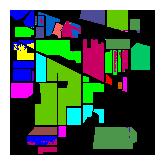

In [8]:
def Draw_Classification_Map(label, name: str, scale: float = 4.0, dpi: int = 400):  # 绘制全分类图

    fig, ax = plt.subplots()
    numlabel = np.array(label)
    v = spectral.imshow(classes=numlabel.astype(np.int16), fignum=fig.number)
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.set_size_inches(label.shape[1] * scale /
                        dpi, label.shape[0] * scale / dpi)
    foo_fig = plt.gcf()  # 'get current figure'
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    foo_fig.savefig(name + '.png', format='png',
                    transparent=True, dpi=dpi, pad_inches=0)
output = output.cpu().detach().numpy()  
output = np.argmax(output,axis=1) 
output = output+1
output = np.reshape(output,(gt.shape[0],gt.shape[1]))  
ids = np.where(gt == 0)
output[ids] = 0            
Draw_Classification_Map(output,'map') 